# Recovering data and creating lithology classification model for Geophysical log data (SEG)

*Marcos Conceição*

In this notebook 4 classification models are trained to classify lithology from Geophysical log data. As one of the dataset columns has missing data, regression model is used for recovering it from other columns.

Model used on regression step: linear regressor.

Model tried in classification:
  - a logistic regressor;
  - a K-nearest neighbors classifier;
  - a decision tree classifier; and
  - a random forest classifier.

## Aknowledgements

- to **SEG** for making the [original dataset](https://github.com/seg/2016-ml-contest) publicly available; and
- to **Alex Cerqueira** for both letting me know of and going through this dataset with the look of an experient machine-learning researcher. He has also edited the original dataset into the one I'm using here.

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            mean_squared_error, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# path = 'facies_vectors.csv'
path = 'facies_vector_alex.csv'
df = pd.read_csv(path)
print(df.columns)
df.head()

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Labels_char', 'PHID',
       'PHIN', 'Formation_num', 'Formation_numsk'],
      dtype='object')


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Labels_char,PHID,PHIN,Formation_num,Formation_numsk
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,Nonmarine fine siltstone,6.965,16.865,1.0,1
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,Nonmarine fine siltstone,5.465,19.665,1.0,1
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,Nonmarine fine siltstone,5.650,20.450,1.0,1
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,Nonmarine fine siltstone,6.165,20.065,1.0,1
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,Nonmarine fine siltstone,6.550,20.050,1.0,1


In [3]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,PHIN,Formation_num,Formation_numsk
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,10.999824,15.402308,6.434322,6.434322
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,8.059673,7.121038,4.722771,4.722771
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000,6.259000,10.025000,2.000000,2.000000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000,8.900000,14.842000,7.000000,7.000000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,13.165000,19.385000,12.000000,12.000000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,13.000000,13.000000


In [4]:
cols = ['Formation_num', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE',
        'NM_M', 'RELPOS', 'PHID', 'PHIN']

numeric = df[cols]
numeric.head()

,Formation_num,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,PHIN
0,1.0,77.45,0.664,9.9,11.915,4.6,1,1.000,6.965,16.865
1,1.0,78.26,0.661,14.2,12.565,4.1,1,0.979,5.465,19.665
2,1.0,79.05,0.658,14.8,13.050,3.6,1,0.957,5.650,20.450
3,1.0,86.10,0.655,13.9,13.115,3.5,1,0.936,6.165,20.065
4,1.0,74.58,0.647,13.5,13.300,3.4,1,0.915,6.550,20.050


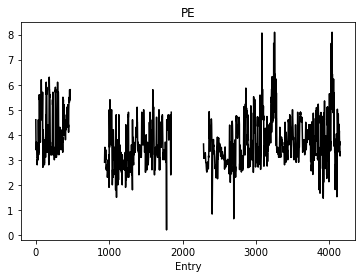

In [5]:
plt.title('PE')
plt.xlabel('Entry')
plt.plot(df.index, df.PE, c='black')

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['Labels_char'])

## Looking for missing data

In [7]:
# does any column has missing entries?
df.columns[df.isnull().any()]

Index(['PE'], dtype='object')

In [8]:
# how many entries?
n = np.sum(df['PE'].isnull())
total = df.shape[0]
print(f'{n} from {total} or {n/total:.0%} of the data.')

917 from 4149 or 22% of the data.


Just part of the column is missing, so we will recover the column with regression.

In [9]:
# does any column has infinite entries?
df.columns[(~np.isfinite(df.isnull())).any()]

Index([], dtype='object')

No.

## Recovering missing PE

In [10]:
# saving old data for later comparison:
oldPE = numeric['PE'].copy()

In [11]:
non_PE_cols = [col
               for col in numeric.columns
               if col != 'PE']

numeric_w_PE = numeric[~numeric['PE'].isnull()]

XPE = numeric_w_PE[non_PE_cols]
yPE = numeric_w_PE['PE']

In [12]:
# scaling data for linear regression
scaler = StandardScaler()
XPE_sc = scaler.fit_transform(XPE)

In [13]:
# preparing holdout cross-validation
XPE_sc_train, XPE_sc_test, yPE_train, yPE_test = \
    train_test_split(XPE_sc, yPE, test_size=0.25)

In [14]:
# training linear regressor
lr = LinearRegression()
lr.fit(XPE_sc_train, yPE_train)

yPE_test_pred = lr.predict(XPE_sc_test)

print(f"Model MSE = {mean_squared_error(yPE_test, yPE_test_pred):.2g}")

Model MSE = 0.37


In [15]:
# recovering PE data

numeric_wo_PE = numeric[numeric['PE'].isnull()]
numeric_wo_PE_idx = numeric_wo_PE.index

XPE = numeric_wo_PE[non_PE_cols]
XPE_sc = scaler.transform(XPE)
numeric.loc[numeric_wo_PE_idx, 'PE'] = lr.predict(XPE_sc)

/home/marcosrdac/.local/share/python_envs/m/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


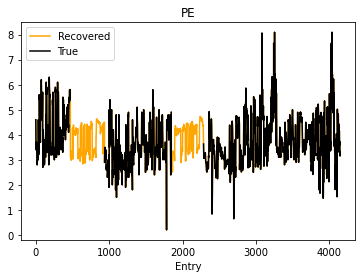

In [16]:
plt.title('PE')
plt.xlabel('Entry')
plt.plot(df.index, numeric['PE'], c='orange', label='Recovered')
plt.plot(df.index, oldPE, c='black', label='True')
plt.legend()

## Training lithology classifier

In [17]:
# numeric columns are going to be features
X = numeric
X.head()

,Formation_num,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,PHIN
0,1.0,77.45,0.664,9.9,11.915,4.6,1,1.000,6.965,16.865
1,1.0,78.26,0.661,14.2,12.565,4.1,1,0.979,5.465,19.665
2,1.0,79.05,0.658,14.8,13.050,3.6,1,0.957,5.650,20.450
3,1.0,86.10,0.655,13.9,13.115,3.5,1,0.936,6.165,20.065
4,1.0,74.58,0.647,13.5,13.300,3.4,1,0.915,6.550,20.050


In [18]:
# lithology will be labels
target = df['Labels_char']
target

0       Nonmarine fine siltstone
1       Nonmarine fine siltstone
2       Nonmarine fine siltstone
3       Nonmarine fine siltstone
4       Nonmarine fine siltstone
                  ...           
4144        Mudstone (limestone)
4145        Mudstone (limestone)
4146        Mudstone (limestone)
4147        Mudstone (limestone)
4148        Mudstone (limestone)
Name: Labels_char, Length: 4149, dtype: object

In [19]:
# encoding categorical features into integers
le = LabelEncoder()
y = le.fit_transform(target)
print("y =", y, end=2*'\n')
print("  where:")
for i, c in enumerate(le.classes_):
    print(f"  {i} := {c}")

y = [4 4 4 ... 2 2 2]

  where:
  0 := Dolomite
  1 := Marine siltstone and shale
  2 := Mudstone (limestone)
  3 := Nonmarine coarse siltstone
  4 := Nonmarine fine siltstone
  5 := Nonmarine sandstone
  6 := Packstone-grainstone (limestone)
  7 := Phylloid-algal bafflestone (limestone)
  8 := Wackestone (limestone)


### Defining a Stratified K-Fold cross-validation function

In [20]:
def stratifiedkfold(model, X, y, n_splits=3, scale=True, metric=accuracy_score, loss_metric=False):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(X, y)

    scaler = None
    X_set = y_set = (None, None)
    best_model = best_model_scaler = None
    mean_train_metric = mean_test_metric = 0.
    best_train_metric = best_test_metric = 0.
    
    for train_idx, test_idx in kf.split(X, y):
        try:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        except AttributeError:
            X_train, X_test = X[train_idx,:], X[test_idx,:]
        try:
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        except AttributeError:
            y_train, y_test = y[train_idx], y[test_idx]
        # scaling data
        if scale:
            scaler = StandardScaler()
            scaler.fit(X_train)
            _X_train = scaler.transform(X_train)
            _X_test = scaler.transform(X_test)
        else:
            _X_train = X_train
            _X_test = X_test
        # training model
        model.fit(_X_train, y_train)
        # cross-validation
        y_train_pred = model.predict(_X_train)
        y_test_pred = model.predict(_X_test)
        train_metric = metric(y_train, y_train_pred)
        test_metric = metric(y_test, y_test_pred)
        # choosing best model
        if loss_metric:
            better = test_metric<best_test_metric and train_metric<best_train_metric
        else:
            better = test_metric>best_test_metric and train_metric>best_train_metric
        if better:
            best_model = model
            best_model_scaler = scaler
            best_train_metric, best_test_metric = train_metric, test_metric
            X_set = X_train, X_test
            y_set = y_train, y_test
        mean_train_metric += train_metric
        mean_test_metric += test_metric
        
    mean_train_metric /= n_splits
    mean_test_metric /= n_splits

    metrics = pd.DataFrame()
    metrics.loc['train', metric.__name__] = mean_train_metric
    metrics.loc['test', metric.__name__] = mean_test_metric
    return metrics, best_model, best_model_scaler, X_set, y_set

def skfshow(model, X, y, **kwargs):
    metric, model, scaler, X_set, y_set = stratifiedkfold(model, X, y, **kwargs)
    if scaler is not None:
        _X = scaler.transform(X_set[0])
    else:
        _X = X_set[0]
    _y = y_set[0]
    plot_confusion_matrix(model, _X, _y, normalize='pred', values_format=".0%")
    print(classification_report(_y,
                                model.predict(_X)))
    return metric, model, scaler, X_set, y_set

## Classification Models

### Logistic regression

              precision    recall  f1-score   support

           0       0.58      0.43      0.49        94
           1       0.49      0.52      0.50       180
           2       0.35      0.21      0.26       198
           3       0.61      0.75      0.68       626
           4       0.70      0.58      0.64       520
           5       0.70      0.54      0.61       179
           6       0.53      0.61      0.57       458
           7       0.76      0.53      0.62       123
           8       0.47      0.52      0.49       388

    accuracy                           0.58      2766
   macro avg       0.58      0.52      0.54      2766
weighted avg       0.58      0.58      0.57      2766



,accuracy_score
train,0.579658
test,0.565678


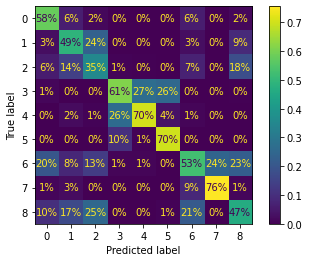

In [21]:
lr = LogisticRegression(max_iter=1000)
metric, model, scaler, X_set, y_set = skfshow(lr, X, y)
metric

### K-Neigbors classifier

              precision    recall  f1-score   support

           0       0.66      0.76      0.70        94
           1       0.66      0.82      0.73       180
           2       0.64      0.61      0.62       198
           3       0.75      0.82      0.78       626
           4       0.79      0.75      0.77       520
           5       0.82      0.79      0.80       179
           6       0.75      0.75      0.75       458
           7       0.86      0.83      0.84       123
           8       0.74      0.61      0.67       388

    accuracy                           0.75      2766
   macro avg       0.74      0.75      0.74      2766
weighted avg       0.75      0.75      0.74      2766



,accuracy_score
train,0.809954
test,0.695348


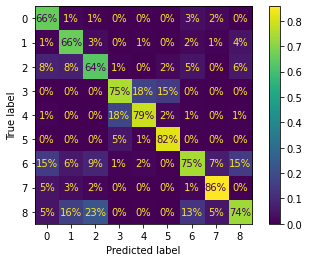

In [22]:
knn = KNeighborsClassifier()
metric, model, scaler, X_set, y_set = skfshow(knn, X, y)
metric

### Decision tree classifier

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        94
           1       0.99      1.00      0.99       181
           2       1.00      0.99      1.00       197
           3       1.00      1.00      1.00       627
           4       1.00      1.00      1.00       520
           5       1.00      1.00      1.00       178
           6       1.00      1.00      1.00       457
           7       0.98      1.00      0.99       124
           8       1.00      1.00      1.00       388

    accuracy                           1.00      2766
   macro avg       1.00      1.00      1.00      2766
weighted avg       1.00      1.00      1.00      2766



,accuracy_score
train,0.998192
test,0.628585


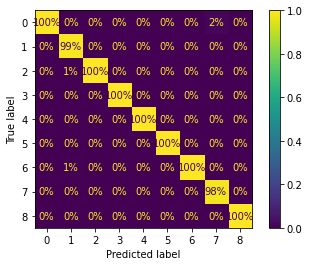

In [23]:
dt = DecisionTreeClassifier()
metric, model, scaler, X_set, y_set = skfshow(dt, X, y, scale=False)
metric

### Random forest classifier

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        94
           1       0.87      0.86      0.86       180
           2       0.86      0.75      0.80       198
           3       0.85      0.88      0.86       626
           4       0.87      0.87      0.87       520
           5       0.92      0.81      0.86       179
           6       0.85      0.89      0.87       458
           7       0.95      0.89      0.92       123
           8       0.81      0.84      0.83       388

    accuracy                           0.86      2766
   macro avg       0.87      0.85      0.86      2766
weighted avg       0.86      0.86      0.86      2766



,accuracy_score
train,0.998433
test,0.725958


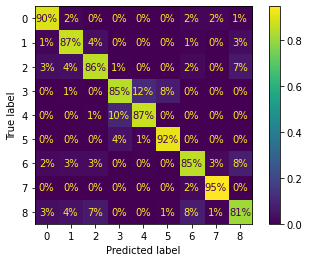

In [24]:
rf = RandomForestClassifier()
metric, model, scaler, X_set, y_set = skfshow(rf, X, y, scale=False)
metric